In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.path.abspath(os.path.join(os.getcwd(),".."))
print(path)
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from dynamics_predict.dynamics_networks import DynamicsNetwork, EncoderDynamicsNetwork, EncoderDecoderDynamicsNetwork, VAEDynamicsNetwork
from rl.policy_networks import DPG_PolicyNetwork
from upesi_utils.load_params import load_params
from upesi_utils.common_func import rand_params
from dynamics_predict.defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from environment import envs
import torch



/home/quantumiracle/research/COS513_project/src
Error: encoder not found!


In [2]:
env_name = 'inverteddoublependulum'
data_path = path+'/data/dynamics_data/'+env_name+'/dynamics.npy'
param_dim = len(DYNAMICS_PARAMS[env_name+'dynamics'])
print('parameter dimension: ', param_dim)

parameter dimension:  5


In [3]:
train_data = np.load(data_path, allow_pickle=True)
print('number of samples in data: ', len(train_data))
# split data
def split_data(data, partial=100000):
    data_s, data_a, data_param, data_s_ = [], [], [], []
    for d in data[:partial]:
        [s,a,param], s_ = d
        data_s.append(s)
        data_a.append(a)
        data_param.append(param)
        data_s_.append(s_)

    data_s = np.array(data_s)
    data_a = np.array(data_a)
    data_param = np.array(data_param)
    data_s_ = np.array(data_s_)
    
    return data_s, data_a, data_param, data_s_

data_s, data_a, data_param, data_s_ = split_data(train_data)
print(data_s.shape, data_a.shape, data_param.shape, data_s_.shape)

number of samples in data:  174559
(100000, 11) (100000, 1) (100000, 5) (100000, 11)


In [4]:
state_dim = data_s.shape[1]
action_dim = data_a.shape[1]
param_dim = data_param.shape[1]
latent_dim = 2
switch_dim = 5

model_save_path = f'../data/weights/dynamics/inverteddoublependulum/'
os.makedirs(model_save_path, exist_ok=True)

## Switch Linear Dynamics

In [5]:
from torch.distributions import Normal
import torch.nn.functional as F
import torch.nn as nn

device = 'cpu'

class DynamicsParamsOptimizer():
    """ 
    Dynamics parameters optimization model (gradient-based) based on a trained 
    forward dynamics prediction network: (s, a, learnable_params) -> s_ with real-world data. 
    """
    def __init__(self, state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path):
        self.model = SLDynamicsNetwork(state_dim, action_dim, param_dim, latent_dim, switch_dim).to(device)
        self.criterion = nn.MSELoss()
        self.model_save_path = model_save_path

    def train(self, s, a, theta, s_, epoch):
        """ s,a concat with param (learnable) -> s_ """
        if not isinstance(s_, torch.Tensor):
            s_ = torch.Tensor(s_).to(device)
        lr_schedule_step = int(epoch/10)  # decay lr for training;  step the scheduler every n epochs

        for ep in range(epoch):
            s_pred = self.model.forward(s, a, theta)
            self.model.optimizer.zero_grad()
            loss = self.criterion(s_pred, s_)
            loss.backward()
            self.model.optimizer.step()
            if ep%100==0:
                print('epoch: {}, loss: {}'.format(ep, loss.item()))
                torch.save(self.model.state_dict(), self.model_save_path+'model')
            

class SLDynamicsNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, param_dim, latent_dim, switch_dim, lr=1e-4):
        super(SLDynamicsNetwork, self).__init__()
        self.state_dim = state_dim
        self.A = nn.Parameter(torch.rand((switch_dim, latent_dim, state_dim, state_dim)), requires_grad=True)
        self.B = nn.Parameter(torch.rand((switch_dim, latent_dim, state_dim, action_dim)), requires_grad=True)
        self.E = nn.Parameter(torch.rand((param_dim, latent_dim)), requires_grad=True)
        self.switch_logits = nn.Sequential(
            nn.Linear(state_dim, switch_dim, bias=False)  # only weight matrix, no bias
        )
        # print(dict(self.named_parameters()))

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def gaussian_noise(self, shape, scale):
        normal = Normal(0, 1)
        epsilon = scale * normal.sample(shape) 
        return epsilon

    def get_switch_var(self, s):
        logits_ = self.switch_logits(s)
        switch_var = F.gumbel_softmax(logits_, tau=1, hard=True)  # if hard, return one-hot
        return switch_var

    def get_s_before_encode(self, s, a):
        switch_var = self.get_switch_var(s)
        A_w = torch.einsum('ab,bcde->acde', switch_var, self.A) # chosen by the switch variable; shape (#batch, #latent, #state, #state)
        B_w = torch.einsum('ab,bcde->acde', switch_var, self.B) # chosen by the switch variable; shape (#batch, #latent, #state, #action)
        s_before_encode = torch.einsum('abcd,ad->abc', A_w, s) + torch.einsum('abcd,ad->abc', B_w, a)  # shape (#batch, #latent, #state)
        return s_before_encode

    def forward(self, s, a, theta):
        if not isinstance(s, torch.Tensor):
            s = torch.Tensor(s).to(device)
        if not isinstance(a, torch.Tensor):
            a = torch.Tensor(a).to(device)
        if not isinstance(theta, torch.Tensor):
            theta = torch.Tensor(theta).to(device)
        batch_size = s.shape[0]

        s_before_encode = self.get_s_before_encode(s, a)
        s_before_noise = torch.einsum('ab,abc->ac', theta@self.E, s_before_encode)  # shape (#batch, #state)
        noise = self.gaussian_noise(shape=(batch_size, self.state_dim), scale=0.)
        s_ = s_before_noise + noise.to(device)

        return s_

    def get_latent_code(self, s, a, s_):
        if not isinstance(s, torch.Tensor):
            s = torch.Tensor(s).to(device).to(device)
        if not isinstance(a, torch.Tensor):
            a = torch.Tensor(a).to(device)        
        if not isinstance(s_, torch.Tensor):
            s_ = torch.Tensor(s_).to(device)     

        s_before_encode = self.get_s_before_encode(s, a)
        inv_s = torch.linalg.pinv(s_before_encode)  # pseudo-inverse; shape (#batch, #state, #latent)
        alpha = torch.einsum('ab,abc->ac', s_, inv_s)
        print(s_before_encode.shape, inv_s.shape, alpha.shape)

        return alpha



In [6]:
import os

# train
updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
updater.train(data_s, data_a, data_param, data_s_, epoch=100000)

epoch: 0, loss: 539.7100830078125
epoch: 100, loss: 491.32183837890625
epoch: 200, loss: 450.0368957519531
epoch: 300, loss: 411.6595764160156
epoch: 400, loss: 376.57781982421875
epoch: 500, loss: 345.4649963378906
epoch: 600, loss: 318.4231872558594
epoch: 700, loss: 293.7621765136719
epoch: 800, loss: 269.6041259765625
epoch: 900, loss: 247.4830780029297
epoch: 1000, loss: 229.0004425048828
epoch: 1100, loss: 210.2208709716797
epoch: 1200, loss: 194.79624938964844
epoch: 1300, loss: 178.97267150878906
epoch: 1400, loss: 165.9069366455078
epoch: 1500, loss: 152.97463989257812
epoch: 1600, loss: 142.20616149902344
epoch: 1700, loss: 131.77296447753906
epoch: 1800, loss: 122.89441680908203
epoch: 1900, loss: 113.36376953125
epoch: 2000, loss: 106.1604232788086
epoch: 2100, loss: 97.84198760986328
epoch: 2200, loss: 91.37669372558594
epoch: 2300, loss: 85.17292785644531
epoch: 2400, loss: 78.93244934082031
epoch: 2500, loss: 73.37200164794922
epoch: 2600, loss: 68.27425384521484
epoch: 

KeyboardInterrupt: 

In [34]:
import numpy

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def display_points(predict_x,true_x):
#     plt.xlim(0,5)
#     plt.ylim(-3,1)
    predict_x = np.array(predict_x)
    true_x = np.array(true_x)
#     colors = get_cmap(predict_x.shape[0])
    
    for i, (x, x_) in enumerate(zip(predict_x, true_x)):
        c=numpy.random.rand(3,)
        # plt.scatter(*x, c=c, markersize=10)
        # plt.plot(*x_,"*", c=c, markersize=8)  
        plt.scatter(*x_, color=c, marker="*", s=80, alpha=0.7)
        plt.scatter(*x, color=c, s=80, label=i,  alpha=0.7)
    plt.xlabel(r'$\alpha_1$')
    plt.ylabel(r'$\alpha_2$')
    plt.legend()
    plt.savefig('compare_sld.png')
    plt.show()

In [10]:
# load test data
test_data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
test_data = np.load(test_data_path, allow_pickle=True)
print('number of samples in dest data: ', len(test_data))
idx=5  # index of sample to test: 0-10
test_s = np.array(test_data[idx]['sa'])[:, :-1]
test_a = np.array(test_data[idx]['sa'])[:, -1:]
test_param = np.array(test_data[idx]['params'])
test_s_ = np.array(test_data[idx]['s_'])
print(test_s.shape, test_a.shape, test_param.shape, test_s_.shape)

# load model
updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
updater.model.load_state_dict(torch.load(model_save_path+'model', map_location=device))

number of samples in dest data:  10
(5333, 11) (5333, 1) (5,) (5333, 11)


<All keys matched successfully>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


torch.Size([1000, 2, 11]) torch.Size([1000, 11, 2]) torch.Size([1000, 2])
tensor([[0.8014, 2.8054],
        [1.0725, 2.1518],
        [0.9140, 2.4149],
        ...,
        [0.8213, 2.1256],
        [0.8427, 2.6282],
        [1.0299, 2.1979]], grad_fn=<ViewBackward0>) [0.9603149 2.1877666] [[0.9228211 2.7533677]]


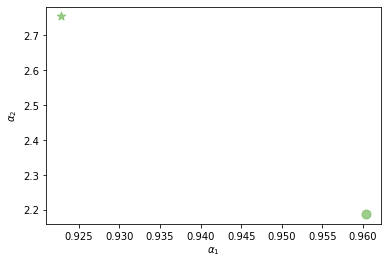

In [19]:
num_test_data = 1000
alpha = updater.model.get_latent_code(test_s[:num_test_data], test_a[:num_test_data], test_s_[:num_test_data])
average_alpha = alpha.mean(dim=0).detach().cpu().numpy()

# compare with encoded value
alpha_ = (torch.Tensor([test_param]).to(device)@updater.model.E).detach().cpu().numpy()
print(alpha, average_alpha, alpha_)

display_points([average_alpha], alpha_)

In [20]:
# load test data
test_data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
test_data = np.load(test_data_path, allow_pickle=True)
print('number of samples in dest data: ', len(test_data))

number of samples in dest data:  10


torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.87254924 2.3232336 ] [0.9297836 2.5999126]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.84321356 2.4151158 ] [0.72224903 3.1760385 ]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.92283404 2.30193   ] [0.9228211 2.7533677]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.8962491 2.4607048] [0.71717197 2.3505447 ]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[1.2178984 1.3055837] [0.87341046 2.1290832 ]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.8634264 2.4905818] [0.8932072 2.5841868]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.9231141 2.0439532] [0.8413188 2.6488624]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.5691488 2.5848022] [0.6726199 2.286192 ]
torch.Size([40, 2, 11]) torch.Size([40, 11, 2]) torch.Size([40, 2])
[0.5876991 3.066546 ] [0

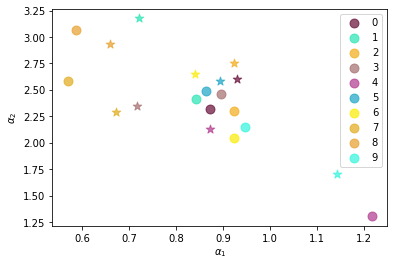

relative error:  0.16430525 0.10185999


In [41]:

data_alpha, data_alpha_ = [], []

for idx in range(10):
#     idx=5  # index of sample to test: 0-10
    test_s = np.array(test_data[idx]['sa'])[:, :-1]
    test_a = np.array(test_data[idx]['sa'])[:, -1:]
    test_param = np.array(test_data[idx]['params'])
    test_s_ = np.array(test_data[idx]['s_'])
    # print(test_s.shape, test_a.shape, test_param.shape, test_s_.shape)

    # load model
    updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
    updater.model.load_state_dict(torch.load(model_save_path+'model', map_location=device))

    num_test_data = 200
    alpha = updater.model.get_latent_code(test_s[:num_test_data], test_a[:num_test_data], test_s_[:num_test_data])
    average_alpha = alpha.mean(dim=0).detach().cpu().numpy()

    # compare with encoded value
    alpha_ = (torch.Tensor([test_param]).to(device)@updater.model.E)[0].detach().cpu().numpy()
    print(average_alpha, alpha_)
    data_alpha.append(average_alpha)
    data_alpha_.append(alpha_)

display_points(data_alpha, data_alpha_)

errs = []
for i, (pred, true) in enumerate(zip(data_alpha, data_alpha_)):
    errs.append(np.linalg.norm(pred-true, 2)/np.linalg.norm(true, 2))
print('relative error: ', np.mean(errs), np.std(errs))

In [22]:
# test on train data
test_size = 20
test_s = data_s[:test_size]
test_a = data_a[:test_size]
test_param = data_param[:test_size]
test_s_ = data_s_[:test_size]

alpha = updater.model.get_latent_code(test_s, test_a, test_s_)

# compare with encoded value
alpha_ = torch.Tensor(test_param)@updater.model.E
print(alpha, alpha_)


torch.Size([20, 2, 11]) torch.Size([20, 11, 2]) torch.Size([20, 2])
tensor([[0.9233, 2.4405],
        [0.9887, 2.2670],
        [0.9265, 2.4414],
        [0.9111, 2.4962],
        [0.9200, 2.4609],
        [0.9278, 2.4210],
        [0.9266, 2.4084],
        [0.9680, 2.3002],
        [1.0700, 2.0149],
        [1.0089, 2.2888],
        [0.8684, 2.5229],
        [0.9369, 2.2211],
        [0.9002, 2.3494],
        [1.0794, 2.3070],
        [1.2722, 1.7704],
        [0.8855, 2.6497],
        [0.8225, 2.5316],
        [0.8823, 2.4986],
        [0.7953, 2.7264],
        [0.8401, 2.4558]], grad_fn=<ViewBackward0>) tensor([[0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.5999],
        [0.9298, 2.599